In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
# 모델을 구현하기 위해서 필요한 라이브러리를 추가한 것입니다.

세로, 가로 :  (112, 92)


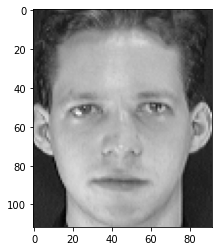

In [39]:
import imageio  # 이미지파일을 읽기 위한 라이브러리입니다.
#이미지 샘플을 하나 확인해보기
im = imageio.imread('./data/1_1.png') #샘플로 data폴더의 1_1.png 파일을 read
plt.imshow(im, cmap='gray') # 이미지 출력해보기
print("세로, 가로 : ",im.shape) # 이미지 가로 세로 픽셀 구하기

In [89]:
data_list = glob('data/*/*.jpg')

def get_label_from_path(path):
    return path.split('\\')[-2]

def read_image(path):
    image = np.array(Image.open(path))
    # Channel 1을 살려주기 위해 reshape 해줌
    return image.reshape(image.shape[0], image.shape[1], 1)
# label 이름을 통해 onehot-encoding 하기 

label_name_list = []
for path in data_list:
    label_name_list.append(get_label_from_path(path))
unique_label_names = np.unique(label_name_list)
print(unique_label_names)
def onehot_encode_label(path):
    onehot_label = unique_label_names == get_label_from_path(path)
    onehot_label = onehot_label.astype(np.uint8)
    return onehot_label
onehot_encode_label(path)

['Aamir_Khan' 'Abhay_Deol' 'Abhishek_Bachchan' 'Aftab_Shivdasani'
 'Aishwarya_Rai' 'Ajay_Devgn' 'Akshay_Kumar' 'Akshaye_Khanna' 'Alia_Bhatt'
 'Ameesha_Patel' 'Amitabh_Bachchan' 'Amrita_Rao' 'Amy_Jackson'
 'Anil_Kapoor' 'Anushka_Sharma' 'Anushka_Shetty' 'Arjun_Kapoor'
 'Arjun_Rampal' 'Arshad_Warsi' 'Asin' 'Ayushmann_Khurrana'
 'Bhumi_Pednekar' 'Bipasha_Basu' 'Bobby_Deol' 'Deepika_Padukone'
 'Disha_Patani' 'Emraan_Hashmi' 'Esha_Gupta' 'Farhan_Akhtar' 'Govinda'
 'Hrithik_Roshan' 'Huma_Qureshi']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [40]:
# 이미지 모두 처리 
x_train = [] # 학습 이미지 담을 변수
y_train = [] # 학습 이미지에 해당하는 라벨
x_test = [] # 테스트 이미지 담을 변수
y_test = [] # 테스트 이미지에 해당하는 라벨

for i in range(unique_label_names):                                                     # 총 40명의 사람
    for j in range(80):                                                 #사람 당 10장
        temp_img = imageio.imread('./data/{}_{}.png'.format(i+1, j+1))  # 사진 한장 불러오기
        if j<8: # 사람당 8장은 학습 이미지로 사용
            x_train.append(temp_img)   # 사진 담기
            y_train.append(i+1)        # 해당 사진의 라벨 달기
        else : # 사람당 2장은 테스트 이미지로 사용
            x_test.append(temp_img)    # 사진 담기
            y_test.append(i+1)         # 해당 사진 라벨 담기

            
# 모두 배열로 변경
x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1)
x_test = np.array(x_test)
y_test = np.array(y_test).reshape(-1,1)

In [41]:
# 라벨 데이터 one-hot 으로 변경 
# 1 --> (1,0,0,0 ...)   2 --> (0,1,0,0,0 ...) 3 -> (0,0,1,0,0 ...) 이런식으로 바꿔주는 작업
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

real_label=y_test # real_label에 one-hot 전 라벨을 담아 놓습니다. 나중에 예측값과 비교해보기 위해서
enc.fit(y_test)
y_test = enc.transform(y_test).toarray()


In [42]:
# 데이터 처리 후 최정형태 확인하기
print("학습 이미지 파일 형태 : ", x_train.shape)   # 320장 * 112 * 92
print("학습 라벨 형태 : ", y_train.shape) # 320장 * 40(one-hot)
print("테스트 이미지 파일 형태 : ", x_test.shape)   # 80장 * 112 * 92
print("테스트 라벨 형태 : ", y_test.shape) # 80장 * 40(one-hot)

x_train = x_train.reshape(320,112,92,1) # 형태 변환 (흑백사진은 뒤에 1을 붙여줘야함, 칼라는 3)
x_test = x_test.reshape(80,112,92,1)    # 형태 변환 (흑백사진은 뒤에 1을 붙여줘야함, 칼라는 3)
y_train = y_tra
# 여기 까지가 데이터 전처리 완료

학습 이미지 파일 형태 :  (320, 112, 92)
학습 라벨 형태 :  (320, 40)
테스트 이미지 파일 형태 :  (80, 112, 92)
테스트 라벨 형태 :  (80, 40)


In [43]:
# CNN (Convolutional Neural Net) 모델 구현하기
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

tf.random.set_seed(1)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', input_shape=(112,92,1))) 
# 16개 filter 사용, 3*3 크기 필터, 활성화 함수는 relu 사용, input 형태는 112,92,1 (세로,가로,흑백)
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(Conv2D(32, (3, 3), activation='relu'))
# 32개 filter 사용, 3*3 크기 필터, 활성화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 맥스풀링 사용, 크기는 2*2, padding 처리

model.add(Conv2D(32, (3, 3), activation='relu'))
# 32개 filter 사용, 3*3 크기 필터, 활설화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 맥스 풀링 사용, 크기는 2*2, padding 처리

# 위와 동일
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
# 추출되는 특징값을 펼치기

model.add(Dense(320, activation='relu', kernel_initializer='he_normal'))
# 분류를 위한 DENSE레이어와 연결, 사용한 뉴런은 320개, 활성화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치노멀 처리

model.add(Dense(40, activation='softmax'))
# 총 40명의 사람을 분류하기 위해 출력층은 40


# 학습 방법은 adam 을 사용
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary() # 구현한 모델 형태 확인해보기, 본 모델은 GPU를 사용하지 않고 돌린다고 가정하여 
                # 미세 기술은 사용하지 않은 모델입니다. 더 좋게 구현이 가능하지만 속도가 너무 느려집니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 90, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 90, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 88, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 88, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 42, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 52, 42, 32)        1

In [44]:
# 모델 학습시키기
model.fit(x_train, y_train,
          batch_size=8, # 배치사이즈 8, 8개 단위로 갱신
          epochs=15,    # 15번의 학습을 의미함. 마음대로 변경 해서 사용 가능
          verbose=1,    # 학습 화면 가시화
          shuffle=True, # 데이터 섞어서 학습
          validation_data=(x_test, y_test))  # validation set은 test set과 동일하게 설정


# 최적화된 모델은 아니지만 최대 98.75%의 성능은 보여줍니다. GPU를 사용하지 못함을 고려하여 가장 간단하게 구현한 형태입니다. 

Epoch 1/15
40/40 [==============================] - 10s 222ms/step - loss: 3.4726 - accuracy: 0.1840 - val_loss: 6.4366 - val_accuracy: 0.0250
Epoch 2/15
40/40 [==============================] - 9s 216ms/step - loss: 0.6592 - accuracy: 0.8725 - val_loss: 2.9929 - val_accuracy: 0.2750
Epoch 3/15
40/40 [==============================] - 9s 232ms/step - loss: 0.1828 - accuracy: 0.9894 - val_loss: 2.2248 - val_accuracy: 0.4625
Epoch 4/15
40/40 [==============================] - 10s 247ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 1.4797 - val_accuracy: 0.6500
Epoch 5/15
40/40 [==============================] - 10s 252ms/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.8833 - val_accuracy: 0.8375
Epoch 6/15
40/40 [==============================] - 10s 251ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.5404 - val_accuracy: 0.9000
Epoch 7/15
40/40 [==============================] - 11s 281ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.3994 - val_accuracy: 0.9250
E

In [46]:
# TEST 데이터로 결과 확인해보기
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1]) # TEST 데이터에 대한 정확도

Test accuracy: 0.9624999761581421


In [47]:
# 모델이 예측한 라벨과 실제 라벨 비교해 보기
# 라벨의 의미 1 = 1번째 사람, 2 = 2번째 사람 .... 40 = 40번째 사람 
real_label = real_label.reshape(-1)
print("실제 라벨 : ",real_label)
pred = model.predict_classes(x_test)
pred = pred+1
print("예측 라벨 : ",pred) 

실제 라벨 :  [ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36
 37 37 38 38 39 39 40 40]


C:\Users\Jung\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


예측 라벨 :  [ 1  1  2  2  3  3  4  4  5 40  6  6  7  7  8  8  9  9 10 12 11 11 12 12
 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 11 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36
 37 37 38 38 39 39 40 40]


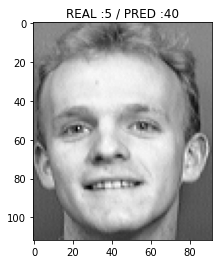

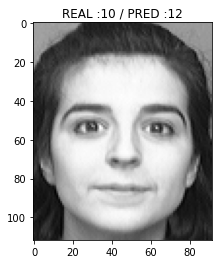

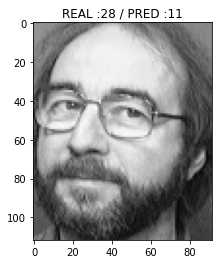

In [48]:
# 실제와 예측이 틀린 index 
index=[]
error=[]
real =[]
for i in range(80):
    if real_label[i]!=pred[i]:
        index.append(i)
        error.append(pred[i])
        real.append(real_label[i])
        
# 틀리게 예측한 이미지 보기 (REAL 이미지)
test_image = x_test.reshape(80,112,92)        
for j in range(len(index)):
    temp = index[j]
    plt.figure()
    plt.title('REAL :{} / PRED :{}'.format(real[j],error[j]))
    plt.imshow(test_image[temp], cmap='gray')